# WGAN on MNIST

In [11]:
import os
import glob
import numpy as np
import h5py
from tqdm import tqdm
from PIL import Image
import cv2
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers.merge import _Merge
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist
import keras.objectives
from keras import backend as K
from functools import partial
import matplotlib.pyplot as plt

%matplotlib inline

## Define Constants

In [2]:
BATCH_SIZE = 32
TRAINING_RATIO = 5
GRADIENT_PENALTY_WEIGHT = 10
output_dir = "../Data/output/CELEBA_GRAYSCALE_64_WGAN/"
num_epochs = 5
filelist = glob.glob("../Data/img_align_celeba/*.jpg")

## Define Loss

In [3]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)


def gradient_penalty_loss(y_true, y_pred, averaged_samples, gradient_penalty_weight):
    gradients = K.gradients(K.sum(y_pred), averaged_samples)
    gradient_l2_norm = K.sqrt(K.sum(K.square(gradients)))
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    return gradient_penalty


class RandomWeightedAverage(_Merge):
    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

## Generator Architecture

In [4]:
def make_generator():
    model = Sequential()
    model.add(Dense(1024, input_dim=100))
    model.add(LeakyReLU())
    model.add(Dense(256 * 8 * 8))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Reshape((8, 8, 256), input_shape=(128 * 8 * 8,)))
    bn_axis = -1
    model.add(Conv2DTranspose(256, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(axis=bn_axis))
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(128, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(axis=bn_axis))
    model.add(LeakyReLU())
    model.add(Conv2DTranspose(64, (5, 5), strides=2, padding='same'))
    model.add(BatchNormalization(axis=bn_axis))
    model.add(LeakyReLU())
    model.add(Convolution2D(1, (5, 5), padding='same', activation='tanh'))
    return model

generator = make_generator()
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              103424    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16384)             16793600  
_________________________________________________________________
batch_normalization_1 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       1638656   
__________

## Discriminator Architecture

In [5]:
def make_discriminator():
    model = Sequential()
    model.add(Convolution2D(64, (5, 5), padding='same', input_shape=(64, 64, 1)))
    model.add(LeakyReLU())
    model.add(Convolution2D(128, (5, 5), kernel_initializer='he_normal', strides=[2, 2], padding='same'))
    model.add(LeakyReLU())
    model.add(Convolution2D(256, (5, 5), kernel_initializer='he_normal', padding='same', strides=[2, 2]))
    model.add(LeakyReLU())
    model.add(Convolution2D(256, (5, 5), kernel_initializer='he_normal', padding='same', strides=[2, 2]))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(1024, kernel_initializer='he_normal'))
    model.add(LeakyReLU())
    model.add(Dense(1, kernel_initializer='he_normal'))
    return model

discriminator = make_discriminator()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1664      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 256)         1638656   
__________

## Helper functions for generating images

In [6]:
def tile_images(image_stack):
    assert len(image_stack.shape) == 3
    image_list = [image_stack[i, :, :] for i in range(image_stack.shape[0])]
    tiled_images = np.concatenate(image_list, axis=1)
    return tiled_images

def generate_images(generator_model, output_dir, epoch, input_z=None):
    if input_z==None:
        input_z = np.random.rand(10,100)
    test_image_stack = generator_model.predict(input_z)
    test_image_stack = (test_image_stack * 127.5) + 127.5
    test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
    tiled_output = tile_images(test_image_stack)
    tiled_output = Image.fromarray(tiled_output, mode='L')
    outfile = os.path.join(output_dir, 'epoch_{}.png'.format(epoch))
    tiled_output.save(outfile)

## Load Data

In [7]:
def load_image(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(64,64))
    img = (img.astype(np.float32)-127.5)/127.5
    return img

def get_batch(batch_size,step_number):
    i = step_number
    X_train = []
    for j in range(i*batch_size,(i+1)*batch_size):
        X_train.append(load_image(filelist[j]))
    X_train = np.array(X_train).reshape(batch_size,64,64,1)
    return X_train

## Compiling the Generator Model

In [8]:
for layer in discriminator.layers:
    layer.trainable = False
discriminator.trainable = False
generator_input = Input(shape=(100,))
generator_layers = generator(generator_input)
discriminator_layers_for_generator = discriminator(generator_layers)
generator_model = Model(inputs=[generator_input], outputs=[discriminator_layers_for_generator])
generator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_loss)

## Compiling the Discriminator Model

In [9]:
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False

real_samples = Input(shape=(64,64,1))
generator_input_for_discriminator = Input(shape=(100,))
generated_samples_for_discriminator = generator(generator_input_for_discriminator)
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)

averaged_samples = RandomWeightedAverage()([real_samples, generated_samples_for_discriminator])
averaged_samples_out = discriminator(averaged_samples)
partial_gp_loss = partial(gradient_penalty_loss,averaged_samples=averaged_samples,gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
partial_gp_loss.__name__ = 'gradient_penalty'

discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator],
                            outputs=[discriminator_output_from_real_samples,
                                     discriminator_output_from_generator,
                                     averaged_samples_out])
discriminator_model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9),loss=[wasserstein_loss,wasserstein_loss,partial_gp_loss])

positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32)

## Training the model

In [10]:
test_z = np.random.rand(10,100)
for epoch in range(num_epochs):
    discriminator_loss = []
    generator_loss = []
    minibatches_size = BATCH_SIZE * TRAINING_RATIO
    num_minibatches = int(len(filelist) // (BATCH_SIZE * TRAINING_RATIO))
    step = 0
    print("Epoch {}:".format(epoch+1))
    for i in tqdm(range(num_minibatches),total=num_minibatches):
        for j in range(TRAINING_RATIO):
            image_batch = get_batch(BATCH_SIZE,step)
            step+=1
            noise = np.random.rand(BATCH_SIZE, 100).astype(np.float32)
            discriminator_loss.append(discriminator_model.train_on_batch([image_batch, noise],[positive_y, negative_y, dummy_y]))
        generator_loss.append(generator_model.train_on_batch(np.random.rand(BATCH_SIZE, 100), positive_y))
    generate_images(generator, output_dir, epoch+1)
    generator_loss_epoch = np.average(generator_loss[-(num_minibatches):],axis=0)
    discriminator_loss_epoch = np.average(discriminator_loss[-(num_minibatches*TRAINING_RATIO):],axis=0)
    print("Generator Loss: {}".format(generator_loss_epoch))
    print("Discriminator Loss: {}".format(discriminator_loss_epoch))
    generator.save_weights("../Models/CELEBA_GRAYSCALE_64_WGAN/G-epoch-{:03d}.hdf5".format(epoch+1))
    discriminator.save_weights("../Models/CELEBA_GRAYSCALE_64_WGAN/D-epoch-{:03d}.hdf5".format(epoch+1))

Epoch 1:


100%|██████████████████████████████████████████████████████████████████████████████| 1266/1266 [57:55<00:00,  2.75s/it]


Generator Loss: -1.2007898092269897
Discriminator Loss: [-0.88497102 -2.18862677  1.22496176  0.07869212]
Epoch 2:


100%|██████████████████████████████████████████████████████████████████████████████| 1266/1266 [57:41<00:00,  2.73s/it]


Generator Loss: 0.4080794155597687
Discriminator Loss: [-0.63002473 -0.27016595 -0.37977433  0.01991575]
Epoch 3:


100%|██████████████████████████████████████████████████████████████████████████████| 1266/1266 [57:41<00:00,  2.73s/it]


Generator Loss: -0.1108238622546196
Discriminator Loss: [-0.56177509 -0.72420216  0.14424491  0.01818348]
Epoch 4:


100%|██████████████████████████████████████████████████████████████████████████████| 1266/1266 [57:59<00:00,  2.75s/it]


Generator Loss: -0.1533191204071045
Discriminator Loss: [-0.5188027  -0.72428674  0.18849152  0.01699216]
Epoch 5:


100%|██████████████████████████████████████████████████████████████████████████████| 1266/1266 [57:58<00:00,  2.75s/it]


Generator Loss: 0.045036159455776215
Discriminator Loss: [-0.48357508 -0.49063835 -0.00886924  0.01593295]


## Testing output

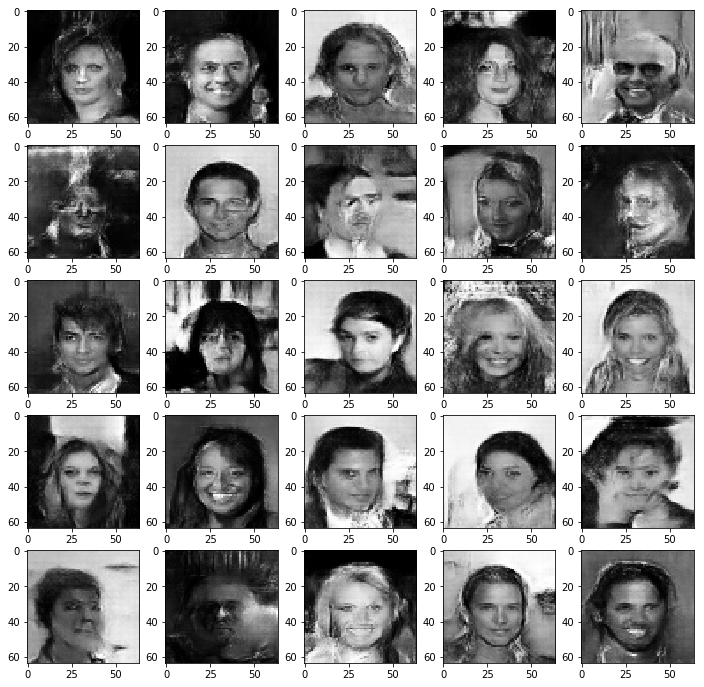

In [14]:
image_output = generator.predict(np.random.rand(25,100))
fig = plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(np.squeeze(image_output[i]),cmap='gray')
plt.show()